In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from random import random, randint, gauss
from ipywidgets import IntProgress
from IPython.display import display

In [2]:
""" Carica file """
total_load = pd.read_excel('C:\\Users\\schesta\\Downloads\\2021-load.xlsx')
total_gen = pd.read_excel('C:\\Users\\schesta\\Downloads\\2021.xlsx')
total_res = pd.read_excel('C:\\Users\\schesta\\Downloads\\2021-res.xlsx')
# total_load_2020_par = pd.read_excel('C:\\Users\\schesta\\Downloads\\2020_load_par.xlsx')
# total_gen_2020_par = pd.read_excel('C:\\Users\\schesta\\Downloads\\2020_gen_par.xlsx')

In [3]:
# total_load = pd.concat([total_load, total_load_2020_par]).sort_values('Date', axis=0)
# total_gen = pd.concat([total_gen, total_gen_2020_par]).sort_values('Date', axis=0)
# step_2020_load = len(total_load_2020_par.index)
# step_2020_gen = len(total_gen_2020_par.index)

In [4]:
""" IPOTESI """
# - Le nuove installazioni di PV ed eolico hanno lo stesso capacity factor (CF) dei sistemi attualmente installlati
# - Gli accumuli hanno una potenza di scarica e carica uguale e indipendente dal livello di carica
# - La stabilità della rete si suppone garantita da altri sistemi e non viene tenuta in considerazione
# - Si eseguono dei bilanci orari, si trascurano le variazioni all'interno di questo arco temporale

' IPOTESI '

In [5]:
""" Generazione da RES tranne fotovoltaico ed eolico """
dates_list = list(set(total_res.Date))
dict_power_pv_w = {}
for _, row in total_res.iterrows():
    date = row.Date.replace(minute=0, second=0)
    if date not in dict_power_pv_w:
        dict_power_pv_w[date] = 0
    if row['Energy Source'] not in ['Thermal', 'Self-consumption', 'Photovoltaic', 'Wind']:
        dict_power_pv_w[date] = dict_power_pv_w[date] + row['Renewable Generation [GWh]'] * 1000

""" Generazione da RES tranne fotovoltaico, biomassa ed eolico """
dates_list = list(set(total_res.Date))
dict_power_pv_w_b = {}
for _, row in total_res.iterrows():
    date = row.Date.replace(minute=0, second=0)
    if date not in dict_power_pv_w_b:
        dict_power_pv_w_b[date] = 0
    if row['Energy Source'] not in ['Thermal', 'Self-consumption', 'Photovoltaic', 'Wind', 'Biomass']:
        dict_power_pv_w_b[date] = dict_power_pv_w_b[date] + row['Renewable Generation [GWh]'] * 1000

""" Complessivo del carico orario """
dates_list = list(set(total_load.Date))
dict_load = {}
for _, row in total_load.iterrows():
    date = row.Date.replace(minute=0, second=0)
    if date not in dict_load:
        dict_load[date] = 0
    dict_load[date] = dict_load[date] + row['Total Load [MW]'] * 0.25  # Dati ogni 15 min
        
        
""" Generazione da solo fotovoltaico """
dates_list = list(set(total_gen.Date))
dict_power_pv = {}
for _, row in total_gen.iterrows():
    date = row.Date.replace(minute=0, second=0)
    if date not in dict_power_pv:
        dict_power_pv[date] = 0
    if row['Primary Source']  == 'Photovoltaic':
        dict_power_pv[date] = dict_power_pv[date] + row['Actual Generation [GWh]'] * 1000
        

""" Generazione da solo eolico """
dates_list = list(set(total_gen.Date))
dict_power_w = {}
for _, row in total_gen.iterrows():
    date = row.Date.replace(minute=0, second=0)
    if date not in dict_power_w:
        dict_power_w[date] = 0
    if row['Primary Source']  == 'Wind':
        dict_power_w[date] = dict_power_w[date] + row['Actual Generation [GWh]'] * 1000
        

""" Generazione da solo biomassa """
dates_list = list(set(total_res.Date))
dict_power_b = {}
for _, row in total_res.iterrows():
    date = row.Date.replace(minute=0, second=0)
    if date not in dict_power_b:
        dict_power_b[date] = 0
    if row['Energy Source']  == 'Biomass':
        dict_power_b[date] = dict_power_b[date] + row['Renewable Generation [GWh]'] * 1000

In [48]:
def simulation(dict_power_pv, dict_power_w, dict_power_pv_w, dict_load, scenarios=100, df_param=None):
    
    storage_size_max = 15e6 #MWh
    storage_size_min = 4.364e3 #MWh attualmente installati - fonte: https://www.infobuildenergia.it/italia-installati-sistemi-di-accumulo-storage/
    storage_max_power_min = 7795 #MW attualmente installati - fonte: https://www.infobuildenergia.it/italia-installati-sistemi-di-accumulo-storage/
    w_factor_max = 20
    pv_factor_max = 20
    base_load_max = 10e3 #MW
    storage_rte = 0.9 # Storage round trip efficiency
    costo_pv = 1 # M€/MW i dati per l'Italia sono di 0.83, approx a 1 per una media con il PV domestico - fonte: https://www.irena.org/Statistics/View-Data-by-Topic/Costs/Global-Trends
    costo_w = 2 # M€/MW una media tra on e off shore - fonte: https://www.irena.org/Statistics/View-Data-by-Topic/Costs/Global-Trends
    costo_n = 7 # M€/MW vedi reattore in Slovacchia - fonte: https://world-nuclear.org/information-library/economic-aspects/economics-of-nuclear-power.aspx
    costo_s = 0.2 # M€/MWh ipotesi solo batterie preso il costo mild al 2030 - fonte: https://www.nrel.gov/docs/fy21osti/79236.pdf
    max_var_base = 100/100
    min_var_base = 70/100

    result_dict = {'thermal_power_max [MW]': [],
                   'thermal_energy [TWh]': [], 
                   'pv_factor': [], 
                   'w_factor': [],
                   'storage_size [GWh]': [],
                   'base_load [MW]': [],
                   'wasted_energy [TWh]': [],
                   'global_cost [MM€]': [], 
                   'base_load_prod': [],
                   'fossil_prod': [], 
                   'score': []}
    
    if isinstance(scenarios, int) and df_param is None:
        no_scenarios = scenarios
    elif df_param is not None:
        no_scenarios = len(df_param.index)
    else:
        print('Error in passing arguments.')
        return
    
    progress_bar = IntProgress(min=0, max=no_scenarios) # instantiate the bar
    display(progress_bar)
    
    for i in range(no_scenarios):
        
        if df_param is None:
            storage_size = storage_size_min + random() * (storage_size_max - storage_size_min) * randint(0, 1)
            storage_max_power = storage_max_power_min * storage_size / storage_size_min #Non viene utilizzato in quanto è sempre più grande l'energia dello storage
            w_factor = randint(100, w_factor_max * 100) / 100
            pv_factor = randint(100, pv_factor_max * 100) / 100
            base_load = randint(1, base_load_max)  * randint(0, 1)
        else:
            storage_size = df_param.storage_size.iloc[i] * 1e3
            w_factor = df_param.w_factor.iloc[i]
            pv_factor = df_param.pv_factor.iloc[i]
            base_load = df_param.base_load.iloc[i]
            
        result_dict['storage_size [GWh]'].append(storage_size/1e3)
        result_dict['w_factor'].append(w_factor)
        result_dict['pv_factor'].append(pv_factor)
        result_dict['base_load [MW]'].append(base_load)
        cost = (pv_factor - 1) * 22 * 1e3 * costo_pv + \
                (w_factor - 1) * 11 *1e3 * costo_w + \
                base_load * costo_n + \
                (storage_size - storage_size_min) * costo_s
        result_dict['global_cost [MM€]'].append(int(cost/1e3))
        thermal_prod = []
        dates = []
        storage = storage_size * 0 # Carico allo 0% quando si parte con la simulazione
        
        if storage_size != 0:
            years_to_simulate = 2
        else:
            years_to_simulate = 1
            
        for _ in range(years_to_simulate):
            thermal = []
            other_uses = []
            hist_base_load = []
            
            for date in dict_power_pv_w:
                dates.append(date)
                tot_prod_base = (dict_power_pv[date] * pv_factor +
                                 dict_power_w[date] * w_factor +
                                 dict_power_pv_w[date] +
                                 base_load * min_var_base)

                # Centrale nucleare da min_var_base a max_var_base in base al carico
                
                if dict_load[date] > tot_prod_base + storage:
                    other_uses.append(0)
                    # Se si riesce a coprire il buco aumentando la produzione del base load
                    if dict_load[date] - tot_prod_base  - storage <= base_load * (max_var_base - min_var_base):
                        hist_base_load.append((dict_load[date] - tot_prod_base - storage + base_load * min_var_base)/base_load)
                        thermal.append(0)
                    else:
                        if base_load != 0:
                            hist_base_load.append(max_var_base)
                        else:
                            hist_base_load.append(0)
                        difetto_tot = dict_load[date] - tot_prod_base - base_load * (max_var_base - min_var_base) - storage
                        thermal.append(difetto_tot)
                    storage = 0
                else:
                    thermal.append(0)
                    if base_load != 0:
                        hist_base_load.append(min_var_base)
                    else:
                        hist_base_load.append(0)
                    if storage + (tot_prod_base - dict_load[date]) * storage_rte < storage_size:
                        storage = storage + (tot_prod_base - dict_load[date]) * storage_rte
                        other_uses.append(0)
                    else:
                        other_uses.append(tot_prod_base - dict_load[date] - (storage_size - storage) / storage_rte)
                        storage = storage_size
                
        result_dict['thermal_power_max [MW]'].append(int(max(thermal)))
        result_dict['thermal_energy [TWh]'].append(int(sum(thermal)/1e3)/1e3)
        result_dict['wasted_energy [TWh]'].append(int(sum(other_uses)/1e3)/1e3)
        result_dict['base_load_prod'].append(int(sum(hist_base_load)/8760*1e3)/1e3)
        result_dict['score'].append((sum(thermal) * 3 + sum(other_uses))/1e6 + (result_dict['global_cost [MM€]'][-1])/10)
        try:
            result_dict['fossil_prod'].append(result_dict['thermal_energy [TWh]'][-1]/result_dict['thermal_power_max [MW]'][-1]/8760*1e6)
        except ZeroDivisionError:
            result_dict['fossil_prod'].append(None)
        progress_bar.value += 1
            
    return result_dict


In [49]:
def filter_low_energy_wasted(opt_result_df):
    
    """ Filtro low energy wasted """
    
    no_we = []
    for count, row in opt_result_df.iterrows():
        if row['wasted_energy [TWh]'] < 30 and row['thermal_energy [TWh]'] < 30:
            no_we.append(count)
            
    return opt_result_df.iloc[no_we]

In [50]:
def filter_score(opt_result_df, score=0.1):
    
    """ Filtro basato sulla score """
    
    if score > 1:
        print('Used 100%')
        score = 1
    elif score < 0:
        print('Not possibile')
        return
    
    total_sample = len(opt_result_df.index)
    good_sample = int(total_sample * score)
    # Sort by "score" but if it is equal minimise the storage size (because it is the most expansive in terms of € and resourse consumption)
    df_sorted = opt_result_df.sort_values(['score', 'storage_size [GWh]'], axis=0)
    
    return df_sorted.head(n=good_sample)

In [51]:
""" Optimization through genetic algorithm """

var = 5/100  # Varianza nella formazione di nuovi parametri
storage_size_min = 4364 #MWh attualmente installati - fonte: https://www.infobuildenergia.it/italia-installati-sistemi-di-accumulo-storage/
storage_size_max = 15e6

opt_result_dict = simulation(dict_power_pv, dict_power_w, dict_power_pv_w, dict_load, scenarios=3000)
opt_result_df = pd.DataFrame(opt_result_dict)
print('Preliminary stage completed.')
random_initial_result = opt_result_df
df_select = []
df_select.append(filter_score(opt_result_df))

if len(df_select[-1].index) == 0:
        print("Condizioni troppo stringenti e/o campione di partenza troppo risicato.")
    
generations = 10
    
for j in range(generations):
    
    # Incrocio dei parametri
    size = len(df_select[-1].index)
    noh = size ** 4  # Number of hybridations
    if noh > 1200:
        noh = 1200

    dict_param = {'storage_size': [],
                 'w_factor': [],
                 'pv_factor': [],
                 'base_load': []}

    # Form the new ones
    for i in range(noh):
        storage_index = randint(0, size-1)
        storage = (df_select[-1]['storage_size [GWh]'].iloc[storage_index]) ** gauss(1, var) * 1e3
        if storage < storage_size_min:
            storage = storage_size_min
        elif storage > storage_size_max:
            storage = storage_size_max
        dict_param['storage_size'].append(storage / 1e3)
        pv_index = randint(0, size-1)
        pv = df_select[-1]['pv_factor'].iloc[pv_index] ** gauss(1, var)
        dict_param['pv_factor'].append(pv if pv > 1 else 1)
        wind_index = randint(0, size-1)
        wind = df_select[-1]['w_factor'].iloc[wind_index] ** gauss(1, var)
        dict_param['w_factor'].append(wind if wind > 1 else 1)
        base_index = randint(0, size-1)
        base = df_select[-1]['base_load [MW]'].iloc[base_index] ** gauss(1, var)
        dict_param['base_load'].append(base)

    df_param = pd.DataFrame(dict_param)
    df_param = df_param.drop_duplicates()
    opt_result_dict = simulation(dict_power_pv, dict_power_w, dict_power_pv_w, dict_load, df_param=df_param)
    opt_result_df = pd.DataFrame(opt_result_dict)
    
    df_select.append(filter_score(opt_result_df))
    
    if len(df_select[-1].index) == 0:
        print("Condizioni troppo stringenti e/o campione di partenza troppo risicato.")
        break

    print('Optimization {}%'.format((j+1)/generations*100))


IntProgress(value=0, max=3000)

Preliminary stage completed.


IntProgress(value=0, max=1200)

Optimization 10.0%


IntProgress(value=0, max=1200)

Optimization 20.0%


IntProgress(value=0, max=1200)

Optimization 30.0%


IntProgress(value=0, max=1200)

Optimization 40.0%


IntProgress(value=0, max=1200)

Optimization 50.0%


IntProgress(value=0, max=1200)

Optimization 60.0%


IntProgress(value=0, max=1200)

Optimization 70.0%


IntProgress(value=0, max=1200)

Optimization 80.0%


IntProgress(value=0, max=1200)

Optimization 90.0%


IntProgress(value=0, max=1200)

Optimization 100.0%


In [154]:
df_select[1]

,thermal_power_max [MW],thermal_energy [TWh],pv_factor,w_factor,storage_size [GWh],base_load [MW],wasted_energy [TWh],global_cost [MM€],base_load_prod,fossil_prod,score
433,17875,5.274,2.305319,5.362317,1492.857825,16186.856825,18.406,327,0.732,0.033681,59.017707
86,23565,7.613,3.521738,4.308544,3368.613397,13739.762617,8.313,425,0.736,0.036879,62.234286
281,15854,5.349,1.423677,5.949522,1086.143543,17928.882182,24.661,302,0.737,0.038515,62.885802
238,20088,20.630,1.069999,5.185174,2724.619591,14163.863024,0.038,326,0.796,0.117235,63.583756
194,24196,18.771,2.270441,5.819139,3515.704274,9603.765911,1.423,366,0.769,0.088560,66.181749
271,28851,18.309,3.870055,6.259013,2335.186460,4581.517892,7.783,315,0.750,0.072444,66.747340
306,19585,17.748,1.559382,3.423392,3769.803294,17924.154931,0.000,412,0.816,0.103448,67.823388
484,27285,9.507,4.324317,4.707389,4024.162723,9931.735807,9.898,451,0.733,0.039775,69.258762
196,25156,10.225,3.730474,6.540275,1265.366925,8123.438246,24.822,295,0.734,0.046400,69.661054
352,25934,11.558,2.839444,6.630466,5549.504353,7354.993149,5.279,473,0.738,0.050876,69.917429


In [17]:
df_select[-1]

,thermal_power_max [MW],thermal_energy [TWh],pv_factor,w_factor,storage_size [GWh],base_load [MW],wasted_energy [TWh],global_cost [MM€],base_load_prod,fossil_prod,score
491,15543,5.382,1.958409,3.170139,897.742811,21976.705881,7.450,192,0.753,0.039528,34.724321
586,14680,5.532,1.851360,3.798916,1459.791330,20320.547721,6.441,204,0.747,0.043018,35.139929
494,15835,5.735,2.028542,3.164338,909.591100,21681.546710,7.352,193,0.754,0.041344,35.255258
272,15070,3.102,2.116388,3.195969,2023.294173,22438.245677,7.715,233,0.732,0.023498,35.669988
171,14424,4.817,1.953858,3.637740,2207.602527,20663.297122,5.872,230,0.743,0.038123,36.097875
...,...,...,...,...,...,...,...,...,...,...,...
925,16424,6.428,1.884542,4.088044,4950.854034,18407.256847,1.141,303,0.746,0.044678,41.084142
282,16517,3.426,2.640566,4.262441,1955.696618,18159.736040,12.050,239,0.724,0.023678,41.089566
530,17756,7.226,2.260118,4.337794,3057.729142,16903.705526,4.866,254,0.746,0.046457,41.106231
441,18161,7.347,2.034850,3.563897,4222.873534,19307.420622,1.605,285,0.754,0.046181,41.126732


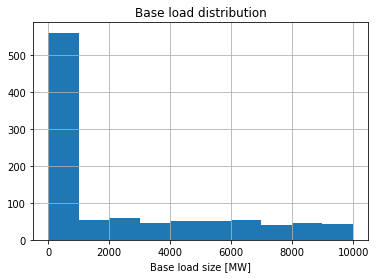

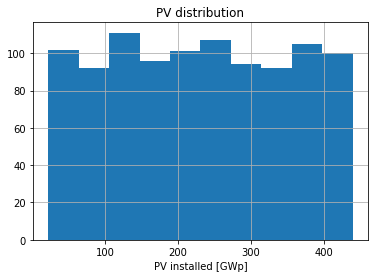

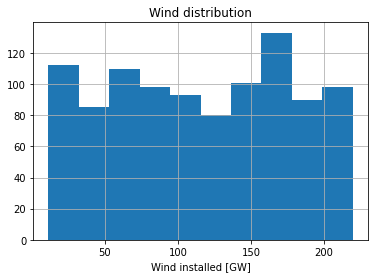

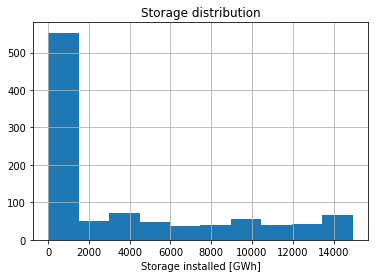

In [148]:
""" First stage """
fig = plt.figure()
plt.hist(random_initial_result['base_load [MW]'])
plt.xlabel('Base load size [MW]')
plt.title('Base load distribution')
plt.grid()

fig2 = plt.figure(2)
plt.hist(random_initial_result['pv_factor'] * 22)
plt.xlabel('PV installed [GWp]')
plt.title('PV distribution')
plt.grid()

fig3 = plt.figure(3)
plt.hist(random_initial_result['w_factor'] * 11)
plt.xlabel('Wind installed [GW]')
plt.title('Wind distribution')
plt.grid()

fig4 = plt.figure(4)
plt.hist(random_initial_result['storage_size [GWh]'])
plt.xlabel('Storage installed [GWh]')
plt.title('Storage distribution')
plt.grid()

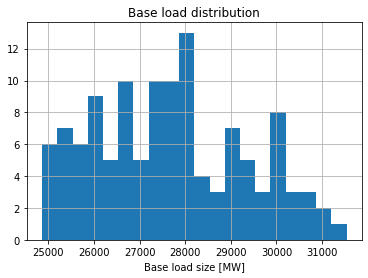

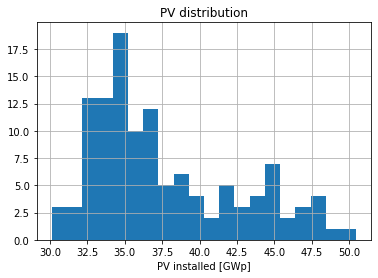

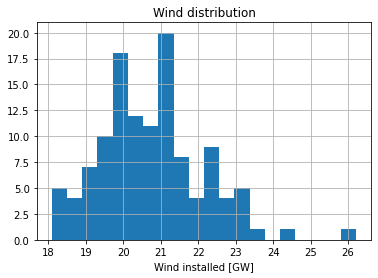

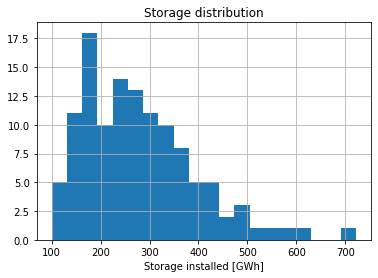

In [52]:
""" Optimized """
fig = plt.figure()
plt.grid()
plt.hist(df_select[-1]['base_load [MW]'], bins=20)
plt.xlabel('Base load size [MW]')
plt.title('Base load distribution')

fig2 = plt.figure(2)
plt.hist(df_select[-1]['pv_factor'] * 22, bins=20)
plt.xlabel('PV installed [GWp]')
plt.title('PV distribution')
plt.grid()

fig3 = plt.figure(3)
plt.hist(df_select[-1]['w_factor'] * 11, bins=20)
plt.xlabel('Wind installed [GW]')
plt.title('Wind distribution')
plt.grid()

fig4 = plt.figure(4)
plt.hist(df_select[-1]['storage_size [GWh]'], bins=20)
plt.xlabel('Storage installed [GWh]')
plt.title('Storage distribution')
plt.grid()

In [71]:
pd.options.display.max_rows = 999

In [159]:
df_select[-1].sort_values(['score', 'storage_size [GWh]'])

,thermal_power_max [MW],thermal_energy [TWh],pv_factor,w_factor,storage_size [GWh],base_load [MW],wasted_energy [TWh],global_cost [MM€],base_load_prod,fossil_prod,score
493,32583,8.962,4.995579,7.035665,6016.909836,320.300634,9.168,345,0.720,0.031399,57.112965
182,32869,7.244,5.095803,7.082531,7286.654230,0.000000,8.432,380,0.000,0.025159,57.299146
319,32830,11.807,4.807329,7.184380,5000.002019,0.000000,9.231,304,0.000,0.041055,57.343107
518,32736,12.460,4.643169,7.367414,4395.736925,0.000000,10.336,284,0.000,0.043450,57.427014
430,32734,9.790,4.972413,7.331314,4393.812234,0.000000,13.598,292,0.000,0.034141,57.484603
278,32799,10.481,4.704119,7.251646,6481.760691,0.000000,7.209,347,0.000,0.036479,57.632340
213,32779,13.834,4.616690,7.295995,4051.159953,0.000000,9.692,272,0.000,0.048178,57.644056
72,32747,5.688,4.903347,7.316743,8499.626791,0.000000,7.813,413,0.000,0.019828,57.645485
250,32906,13.387,4.985841,7.031517,3566.348355,0.000000,11.272,265,0.000,0.046441,57.854560
196,32111,9.683,5.046742,6.887401,4796.558358,874.585739,11.378,320,0.722,0.034423,57.903588


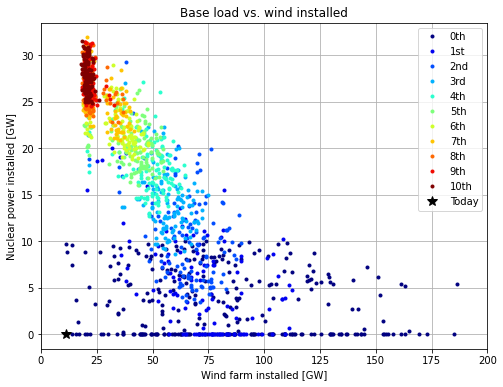

In [87]:
""" Wind installed vs. base load """
import matplotlib.pylab as pl
colors = pl.cm.jet(np.linspace(0,1,len(df_select)))

fig = plt.figure(figsize=(8, 6))
i = 0
for df in df_select:
    plt.plot(df['w_factor']*11, df['base_load [MW]']/1e3, '.', color=colors[i])
    i = i + 1
plt.plot(11, 0, 'k*', markersize=10)
fig.axes[0].grid()
plt.xlim(0, 200)
# plt.ylim(0, 30e3)
plt.xlabel('Wind farm installed [GW]')
plt.ylabel('Nuclear power installed [GW]')
plt.title('Base load vs. wind installed')
plt.legend(['0th', '1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', 'Today'])
plt.savefig("Evolution nuclear vs wind.jpeg")

Text(0.5, 1.0, 'Wind installed vs. base load')

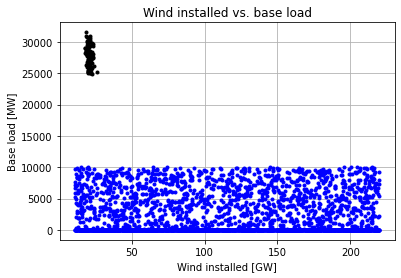

In [54]:
""" Wind installed vs. base load """
fig = plt.figure()
plt.plot(df_select[-1]['w_factor']*11, df_select[-1]['base_load [MW]'], 'k.')
plt.plot(random_initial_result['w_factor']*11, random_initial_result['base_load [MW]'], 'b.')
fig.axes[0].grid()
# plt.xlim(0, 200)
# plt.ylim(0, 40e3)
plt.xlabel('Wind installed [GW]')
plt.ylabel('Base load [MW]')
plt.title('Wind installed vs. base load')

Text(0.5, 1.0, 'PV installed vs. base load')

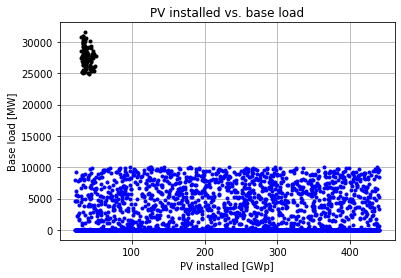

In [55]:
""" PV installed vs. base load """
fig = plt.figure()
plt.plot(df_select[-1]['pv_factor']*22, df_select[-1]['base_load [MW]'], 'k.')
plt.plot(random_initial_result['pv_factor']*22, random_initial_result['base_load [MW]'], 'b.')
fig.axes[0].grid()
# plt.xlim(0, 200)
# plt.ylim(0, 40e3)
plt.xlabel('PV installed [GWp]')
plt.ylabel('Base load [MW]')
plt.title('PV installed vs. base load')

Text(0.5, 1.0, 'Wind installed vs. storage')

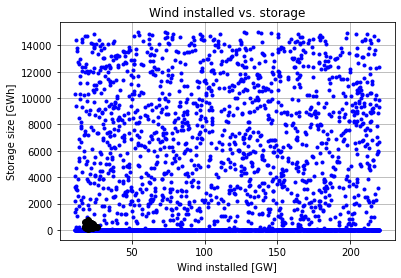

In [56]:
""" Wind installed vs. storage """
fig = plt.figure()
plt.plot(random_initial_result['w_factor']*11, random_initial_result['storage_size [GWh]'], 'b.')
plt.plot(df_select[-1]['w_factor']*11, df_select[-1]['storage_size [GWh]'], 'ko')
fig.axes[0].grid()
# plt.xlim(0, 70)
# plt.ylim(0, 6e3)
plt.xlabel('Wind installed [GW]')
plt.ylabel('Storage size [GWh]')
plt.title('Wind installed vs. storage')

Text(0.5, 1.0, 'Wind vs. PV installed')

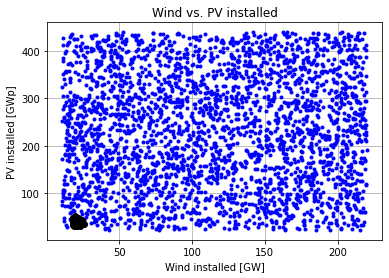

In [57]:
""" Wind installed vs. PV installed """
fig = plt.figure()
plt.plot(random_initial_result['w_factor']*11, random_initial_result['pv_factor']*22, 'b.')
plt.plot(df_select[-1]['w_factor']*11, df_select[-1]['pv_factor']*22, 'ko')
fig.axes[0].grid()
# plt.xlim(0, 200)
# plt.ylim(0, 40e3)
plt.xlabel('Wind installed [GW]')
plt.ylabel('PV installed [GWp]')
plt.title('Wind vs. PV installed')

Text(0.5, 1.0, 'PV installed vs. storage')

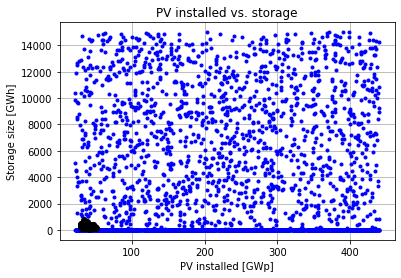

In [58]:
""" PV installed vs. storage """
fig = plt.figure()
plt.plot(random_initial_result['pv_factor']*22, random_initial_result['storage_size [GWh]'], 'b.')
plt.plot(df_select[-1]['pv_factor']*22, df_select[-1]['storage_size [GWh]'], 'ko')
fig.axes[0].grid()
# plt.xlim(0, 200)
# plt.ylim(0, 6e3)
plt.xlabel('PV installed [GWp]')
plt.ylabel('Storage size [GWh]')
plt.title('PV installed vs. storage')

Text(0.5, 1.0, 'Score vs. base load')

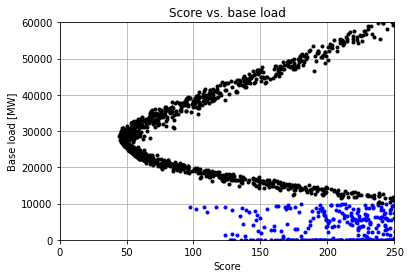

In [63]:
""" Score vs. base load """
fig = plt.figure()
plt.plot(random_initial_result['score'], random_initial_result['base_load [MW]'], 'b.')
plt.plot(opt_result_df['score'], opt_result_df['base_load [MW]'], 'k.')
fig.axes[0].grid()
plt.xlim(0, 250)
plt.ylim(0, 60e3)
plt.xlabel('Score')
plt.ylabel('Base load [MW]')
plt.title('Score vs. base load')

Text(0.5, 1.0, 'PV installed vs. base load')

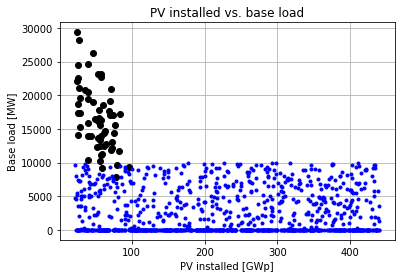

In [143]:
""" PV vs. base load """
fig = plt.figure()
plt.plot(df_select[-1]['pv_factor']*22, df_select[-1]['base_load [MW]'], 'ko')
plt.plot(random_initial_result['pv_factor']*22, random_initial_result['base_load [MW]'], 'b.')
fig.axes[0].grid()
# plt.xlim(0, 200)
# plt.ylim(0, 40e3)
plt.xlabel('PV installed [GWp]')
plt.ylabel('Base load [MW]')
plt.title('PV installed vs. base load')

In [142]:
""" Wind installed vs. base load """
fig = plt.figure()
plt.plot(df_select['pv_factor']*11, df_select['base_load [MW]'], 'ro')
plt.plot(random_initial_result['pv_factor']*11, random_initial_result['base_load [MW]'], 'b.')
fig.axes[0].grid()
plt.xlim(0, 50)
plt.ylim(0, 40e3)
plt.xlabel('PV installed [GWp]')
plt.ylabel('Base load [MW]')
plt.title('PV installed vs. base load')

TypeError: list indices must be integers or slices, not str

<Figure size 432x288 with 0 Axes>

In [75]:
# df_select.to_csv('10g_6GW6_base_load_no_waste.csv')

In [85]:
filter_low_energy_wasted(opt_result_df)

,thermal_power_max [MW],thermal_energy [TWh],pv_factor,w_factor,storage_size [GWh],base_load [MW],wasted_energy [TWh],global_cost [MM€],base_load_prod,fossil_prod
6,26059,42.360,3.067255,3.527019,0.492,11361.712020,18.484,152,0.897,0.185564
28,32930,45.477,2.520403,7.285332,96.905,4067.018523,29.185,144,0.877,0.157651
32,31792,50.887,2.715258,5.773026,55.134,5377.536670,18.401,138,0.893,0.182719


[7, 4, 46, 467]